# Introduzione

Il dataset è presente su [Kaggle](https://www.kaggle.com/datasets/fournierp/captcha-version-2-images).

Le immagini sono parole formate da 5 caratteri alfanumerici, sono presenti inoltre sfocature e linee.

Il dataset contiene 1040 immagini in formato png e 30 immagini in formato jpg, per un totale di 1070 immagini CAPTCHA con dimensioni 200x50. La label di ogni campione è una stringa, ovvero il nome del file meno l'estensione del file stesso. Tale stringa è uguale ai caratteri alfanumerici dell'immagine.

Lo scopo di questo notebook è quello di riconoscere i caratteri alfanumerici presenti nelle immagini [CAPTCHA](https://it.wikipedia.org/wiki/CAPTCHA).

# Setup ambiente

In [ ]:
# Installa PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=76008d7a93d78d918e4cd9f1e6b1ce1da07f9c080909af72f4a2ffad08a8be50
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf
import pyspark as ps
import timeit
import time
import datetime

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
from pathlib import Path

In [ ]:
# Crea SparkContext
#sc = ps.SparkContext.getOrCreate('local[*]')
sc = ps.SparkContext('local[*]')

In [ ]:
drive.mount('/content/drive/')
path = 'drive/My Drive/samples'

Mounted at /content/drive/


In [ ]:
print('Versione Tensorflow:', tf.__version__)

gpu_device_name = tf.test.gpu_device_name()
if gpu_device_name != '/device:GPU:0':
    raise SystemError('GPU non trovata')
print('GPU:', gpu_device_name)

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

cpu()
gpu()

cpu_time = timeit.timeit('cpu()', number=10, setup='from __main__ import cpu')
print('Tempo impiegato utilizzando la CPU:', cpu_time)
gpu_time = timeit.timeit('gpu()', number=10, setup='from __main__ import gpu')
print('Tempo impiegato utilizzando la GPU:', gpu_time)
print('Velocità GPU rispetto alla CPU: {}x'.format(int(cpu_time/gpu_time)))

Versione Tensorflow: 2.12.0
GPU: /device:GPU:0
Tempo impiegato utilizzando la CPU: 3.838162651999994
Tempo impiegato utilizzando la GPU: 0.0873327460000155
Velocità GPU rispetto alla CPU: 43x


# Esplorazione dati

In [ ]:
data_dir = Path(path)
images = list(data_dir.glob('*.*'))
print('Immagini trovate: {}\n'.format(len(images)))

chars_and_numbers = []
dataset = []
for i in images:
    chars_and_numbers.append([*i.stem])
    split = i.name.split('.')
    label = split[0]
    extension = split[1]
    dataset.append((str(i), label, extension))

captcha_rdd = sc.parallelize(chars_and_numbers).flatMap(lambda xs: [x[0] for x in xs]).map(
                                                        lambda x: (x, 1)).reduceByKey(
                                                        lambda x,y: x + y)

chars_count = 0
char_set = set()
numbers_count= 0
number_set = set()
for i in captcha_rdd.collect():
    key = i[0]
    value = i[1]
    if key.isnumeric():
        numbers_count += value
        number_set.add(key)
    else:
        chars_count += value
        char_set.add(key)

print('Caratteri trovati:', chars_count)
print('Caratteri unici trovati: {}\n'.format(len(char_set)))
print('Numeri trovati:', numbers_count)
print('Numeri unici trovati: {}\n'.format(len(number_set)))

df = pd.DataFrame(dataset, columns=['path', 'label', 'extension'], index=None)
df.head()

Immagini trovate: 1070

Caratteri trovati: 3431
Caratteri unici trovati: 12

Numeri trovati: 1919
Numeri unici trovati: 7



,path,label,extension
0,drive/My Drive/samples/4egem.png,4egem,png
1,drive/My Drive/samples/4exnn.png,4exnn,png
2,drive/My Drive/samples/4fc36.png,4fc36,png
3,drive/My Drive/samples/4f8yp.png,4f8yp,png
4,drive/My Drive/samples/4fp5g.png,4fp5g,png


# Visualizzazione dati

In [ ]:
df2 = df.groupby(['extension']).count().reset_index()
df2.columns.values[0] = 'Estensione'
df2.columns.values[1] = 'Conteggio'
df2 = df2[['Estensione', 'Conteggio']]

fig = px.pie(df2,
             values='Conteggio',
             names='Estensione',
             title='Percentuale estensioni immagini',
             color_discrete_sequence=px.colors.sequential.Darkmint)
fig.show()

In [ ]:
fig = px.bar(pd.DataFrame(captcha_rdd.filter(lambda x: x[0].isalpha()).collect()).set_index(0).sort_values(by=1, ascending=False),
       labels={'value': 'Conteggio'},
       color='value',
       color_continuous_scale='tempo',
       text_auto=True)
fig.update_layout(xaxis_title='Caratteri')
fig.show()

In [ ]:
fig = px.bar(pd.DataFrame(captcha_rdd.filter(lambda x: x[0].isnumeric()).collect()).set_index(0).sort_values(by=1, ascending=False),
       labels={'value': 'Conteggio'},
       color='value',
       color_continuous_scale='tempo',
       text_auto=True)
fig.update_layout(xaxis_title='Numeri')
fig.show()

# Caricamento dati e preprocessamento

In [ ]:
images = sorted(list(map(str, list(Path(path).glob('*.png')))))
labels = [img.split(os.path.sep)[-1].split('.png')[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

batch_size = 16
img_width = 200
img_height = 50
downsample_factor = 4

max_length = max([len(label) for label in labels])

In [ ]:
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

# Creazione train set e validation set

In [ ]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [ ]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    return {'image': img, 'label': label}

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

# Visualizzazione immagini

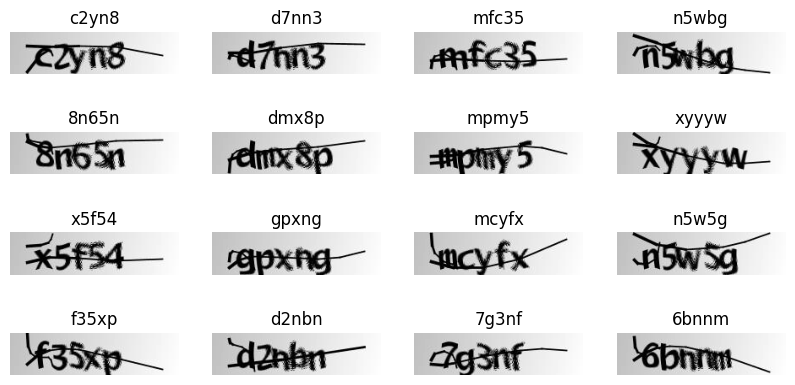

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch['image']
    labels = batch['label']
    for i in range(16):
        img = (images[i] * 255).numpy().astype('uint8')
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode('UTF-8')
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap='gray')
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis('off')
plt.show()

# Creazione modello

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [ ]:
def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name='image', dtype='float32')
    labels = layers.Input(name='label', shape=(None,), dtype='float32')

    x = layers.Conv2D(
        16,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv1',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)

    x = layers.Conv2D(
        32,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv2',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)

    x = layers.Conv2D(
        64,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv3',
    )(x)
    x = layers.MaxPooling2D((2, 2), name='pool3')(x)

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2')(x)

    output = CTCLayer(name='ctc_loss')(labels, x)

    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name='ocr_model_v1')
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model

In [ ]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv2 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool2 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv2[0][0]']                  
                                                                                                  
 Conv3 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool2[0][0]']       

# Addestramento modello

In [ ]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
time_callback = TimeHistory()
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    callbacks=[time_callback],
    epochs=100
)
times = time_callback.times

Epoch 1/100
59/59 [==============================] - 21s 76ms/step - loss: 21.2811 - val_loss: 16.3046
Epoch 2/100
59/59 [==============================] - 3s 45ms/step - loss: 16.3766 - val_loss: 16.2710
Epoch 3/100
59/59 [==============================] - 4s 63ms/step - loss: 16.3615 - val_loss: 16.2737
Epoch 4/100
59/59 [==============================] - 5s 79ms/step - loss: 16.3538 - val_loss: 16.2762
Epoch 5/100
59/59 [==============================] - 3s 58ms/step - loss: 16.3465 - val_loss: 16.2800
Epoch 6/100
59/59 [==============================] - 3s 57ms/step - loss: 16.3404 - val_loss: 16.2809
Epoch 7/100
59/59 [==============================] - 3s 49ms/step - loss: 16.3366 - val_loss: 16.2846
Epoch 8/100
59/59 [==============================] - 3s 45ms/step - loss: 16.3349 - val_loss: 16.2861
Epoch 9/100
59/59 [==============================] - 3s 49ms/step - loss: 16.3180 - val_loss: 16.2851
Epoch 10/100
59/59 [==============================] - 3s 46ms/step - loss: 16.292

In [ ]:
seconds = sc.parallelize(times).reduce(lambda x, y: x + y)
print('Tempo impiegato per addestrare il modello:', datetime.timedelta(seconds=seconds))

Tempo impiegato per addestrare il modello: 0:05:24.793614


Text(0.5, 1.0, 'Loss function')

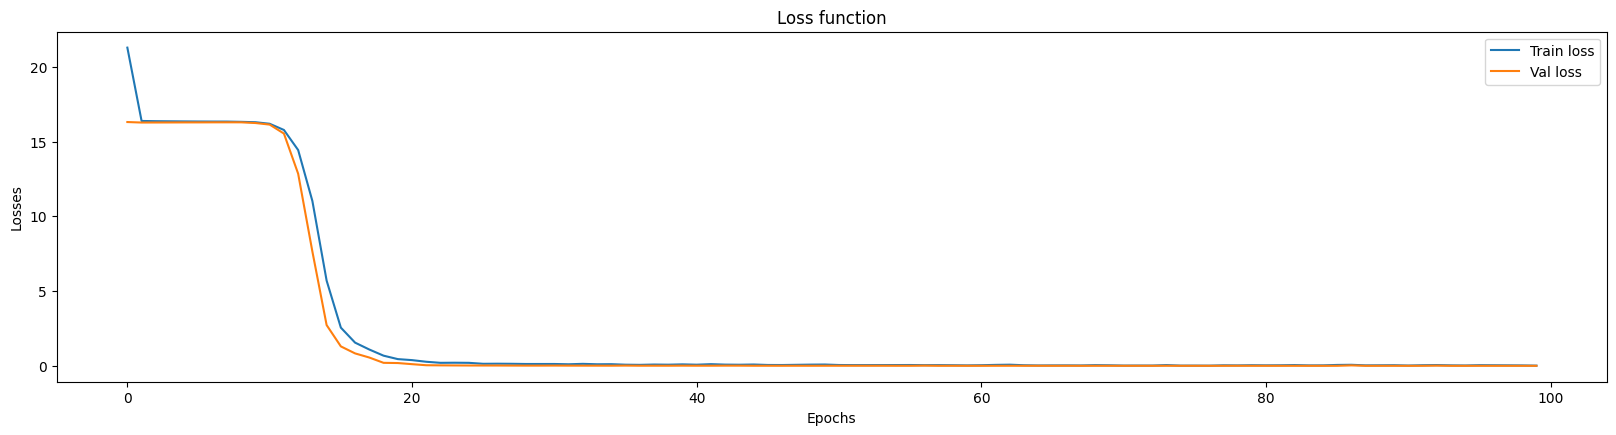

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['Train loss','Val loss'])
plt.title('Loss function')

# Salva il modello

In [ ]:
model_path = 'drive/My Drive/model/model.keras'

In [ ]:
model.save(model_path, overwrite=False)

[WARNING] drive/My Drive/model/model.keras already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


# Predizioni

In [ ]:
# Carica modello salvato su Drive
custom_objects = {'CTCLayer': CTCLayer}
with keras.utils.custom_object_scope(custom_objects):
    loaded_model = tf.keras.models.load_model(model_path)

prediction_model = keras.models.Model(loaded_model.get_layer(name='image').input, loaded_model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv2 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool2 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv3 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool3 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

1/1 [==============================] - 2s 2s/step


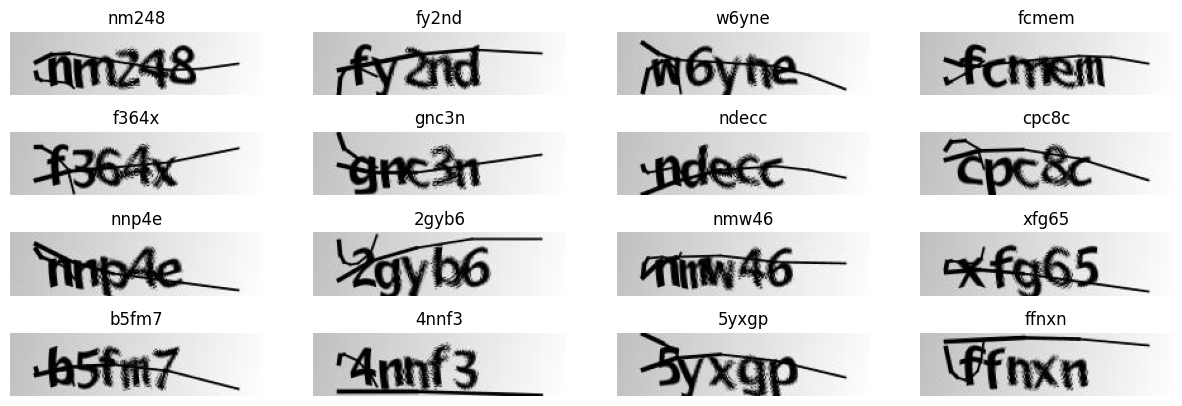

In [ ]:
for batch in validation_dataset.take(1):
    batch_images = batch['image']
    batch_labels = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = pred_texts[i]
        ax[i // 4, i % 4].imshow(img, cmap='gray')
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis('off')

plt.show()

# Accuratezza

In [ ]:
def plot_accuracy(successes, errors):
    print('Valori predetti:', successes + errors)
    print('Valori correttamente predetti:', successes)
    print('Valori erroneamente predetti:', errors)
    print('')
    px.pie(pd.DataFrame({'names': ['Successi', 'Errori'], 'values': [successes, errors]}),
           values='values',
           names='names',
           title='Percentuale successi/errori',
           color_discrete_sequence=['#00cc96', '#ef553b']).show()

In [ ]:
def plot_wrong_predictions(path, prediction_list, image_extension):
    for i in prediction_list:
        print('Testo erroneamente predetto:', i[0])
        print('Testo originale:', i[1])
        img = cv2.imread(path + '/' + i[1] + image_extension , cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_AREA)
        plt.imshow(img, 'gray')
        plt.axis('off')
        plt.show()
        print('')

## Validation set

In [ ]:
successes = 0
errors = 0
wrong_predictions = []

for batch in validation_dataset:
    batch_images = batch['image']
    batch_labels = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('UTF-8')
        orig_texts.append(label)

    for i in range(len(pred_texts)):
        predicted_value = str(pred_texts[i])
        label = str(orig_texts[i])
        if predicted_value == str(orig_texts[i]):
            successes += 1
        else:
            wrong_predictions.append((predicted_value, label))
            errors += 1

plot_accuracy(successes, errors)
print('')
plot_wrong_predictions(path, wrong_predictions, '.png')

1/1 [==============================] - 0s 26ms/step
Valori predetti: 104
Valori correttamente predetti: 104
Valori erroneamente predetti: 0



## Immagini jpg

In [ ]:
image_extension = '.jpg'
images = sorted(list(map(str, list(Path(path).glob('*' + image_extension)))))
labels = [img.split(os.path.sep)[-1].split(image_extension)[0] for img in images]
successes = 0
errors = 0
wrong_predictions = []

for i in range(len(images)):
    image = np.expand_dims(encode_img(str(images[i])), axis=0)
    predicted_value = decode_batch_predictions(prediction_model.predict(image))[0]
    label = labels[i]

    if predicted_value == label:
        successes += 1
    else:
        wrong_predictions.append((predicted_value, label))
        errors += 1

plot_accuracy(successes, errors)
print('')
plot_wrong_predictions(path, wrong_predictions, image_extension)

1/1 [==============================] - 0s 25ms/step
Valori predetti: 30
Valori correttamente predetti: 30
Valori erroneamente predetti: 0



## Validation set + immagini jpg

In [ ]:
successes = 0
errors = 0

for batch in validation_dataset:
    batch_images = batch['image']
    batch_labels = batch['label']
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('UTF-8')
        orig_texts.append(label)
    for i in range(len(pred_texts)):
        predicted_value = str(pred_texts[i])
        label = str(orig_texts[i])
        if predicted_value == str(orig_texts[i]):
            successes += 1
        else:
            errors += 1

images = sorted(list(map(str, list(Path(path).glob('*' + image_extension)))))
labels = [img.split(os.path.sep)[-1].split(image_extension)[0] for img in images]
for i in range(len(images)):
    image = np.expand_dims(encode_img(str(images[i])), axis=0)
    predicted_value = decode_batch_predictions(prediction_model.predict(image))[0]
    label = labels[i]
    if predicted_value == label:
        successes += 1
    else:
        errors += 1

plot_accuracy(successes, errors)

1/1 [==============================] - 0s 34ms/step
Valori predetti: 134
Valori correttamente predetti: 134
Valori erroneamente predetti: 0



## Lettere maiuscole

1/1 [==============================] - 0s 24ms/step
Testo erroneamente predetto: [UNK][UNK][UNK][UNK][UNK]
Testo originale: 6vuxM


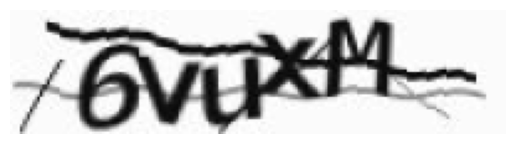


Testo erroneamente predetto: [UNK][UNK][UNK][UNK][UNK]
Testo originale: C38fM


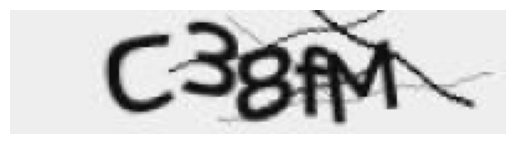


Testo erroneamente predetto: f4[UNK][UNK][UNK]
Testo originale: dY2iw


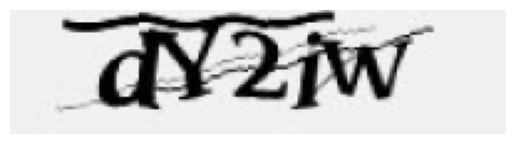


Testo erroneamente predetto: [UNK][UNK][UNK][UNK][UNK]
Testo originale: yD33B


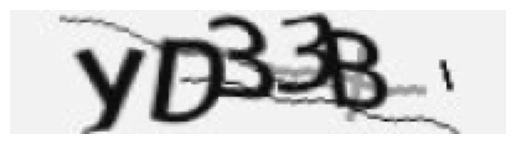


Testo erroneamente predetto: [UNK][UNK][UNK][UNK][UNK]
Testo originale: zvJwd


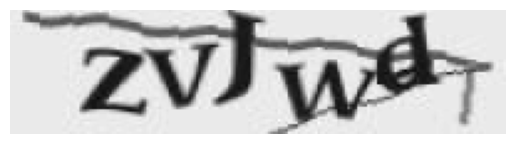

In [ ]:
archive_path = 'drive/My Drive/new_samples'
image_extension = '.jpg'
images = sorted(list(map(str, list(Path(archive_path).glob('*' + image_extension)))))
labels = [img.split(os.path.sep)[-1].split(image_extension)[0] for img in images]
wrong_predictions = []

for i in range(len(images)):
    image = np.expand_dims(encode_img(str(images[i])), axis=0)
    predicted_value = decode_batch_predictions(prediction_model.predict(image))[0]
    wrong_predictions.append((predicted_value, labels[i]))

plot_wrong_predictions(archive_path, wrong_predictions, image_extension)